# DECAGON Training

In [1]:
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations, chain
import time
import os
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics
import pandas as pd
import psutil
import pickle
from decagon.deep.optimizer import DecagonOptimizer
from decagon.deep.model import DecagonModel
from decagon.deep.minibatch import EdgeMinibatchIterator
from decagon.utility import rank_metrics, preprocessing

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Train on GPU
#os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

In [4]:
# psutil & time BEGIN
start = time.time() #in seconds
pid = os.getpid()
ps= psutil.Process(pid)

# Import Data from previous computations

In [5]:
filename = './data/data_structures/DECAGON_toy_test'
with open(filename, 'rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

nonzero_feat Imported successfully
edge_type2dim Imported successfully
adj_mats_orig Imported successfully
edge_type2decoder Imported successfully
degrees Imported successfully
edge_types Imported successfully
num_edge_types Imported successfully
num_feat Imported successfully
feat Imported successfully


# Functions

In [6]:
def get_accuracy_scores(edges_pos, edges_neg, edge_type):
    feed_dict.update({placeholders['dropout']: 0})
    feed_dict.update({placeholders['batch_edge_type_idx']: minibatch.edge_type2idx[edge_type]})
    feed_dict.update({placeholders['batch_row_edge_type']: edge_type[0]})
    feed_dict.update({placeholders['batch_col_edge_type']: edge_type[1]})
    rec = sess.run(opt.predictions, feed_dict=feed_dict)

    def sigmoid(x):
        return 1. / (1 + np.exp(-x))

    # Predict on test set of edges
    preds = []
    actual = []
    predicted = []
    edge_ind = 0
    for u, v in edges_pos[edge_type[:2]][edge_type[2]]:
        score = sigmoid(rec[u, v])
        preds.append(score)
        assert adj_mats_orig[edge_type[:2]][edge_type[2]][u,v] == 1, 'Problem 1'

        actual.append(edge_ind)
        predicted.append((score, edge_ind))
        edge_ind += 1

    preds_neg = []
    for u, v in edges_neg[edge_type[:2]][edge_type[2]]:
        score = sigmoid(rec[u, v])
        preds_neg.append(score)
        assert adj_mats_orig[edge_type[:2]][edge_type[2]][u,v] == 0, 'Problem 0'

        predicted.append((score, edge_ind))
        edge_ind += 1

    preds_all = np.hstack([preds, preds_neg])
    preds_all = np.nan_to_num(preds_all)
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    predicted = list(zip(*sorted(predicted, reverse=True, key=itemgetter(0))))[1]

    roc_sc = metrics.roc_auc_score(labels_all, preds_all)
    aupr_sc = metrics.average_precision_score(labels_all, preds_all)
    apk_sc = rank_metrics.apk(actual, predicted, k=50)

    return roc_sc, aupr_sc, apk_sc


def construct_placeholders(edge_types):
    placeholders = {
        'batch': tf.placeholder(tf.int32, name='batch'),
        'batch_edge_type_idx': tf.placeholder(tf.int32, shape=(), name='batch_edge_type_idx'),
        'batch_row_edge_type': tf.placeholder(tf.int32, shape=(), name='batch_row_edge_type'),
        'batch_col_edge_type': tf.placeholder(tf.int32, shape=(), name='batch_col_edge_type'),
        'degrees': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
    }
    placeholders.update({
        'adj_mats_%d,%d,%d' % (i, j, k): tf.sparse_placeholder(tf.float32)
        for i, j in edge_types for k in range(edge_types[i,j])})
    placeholders.update({
        'feat_%d' % i: tf.sparse_placeholder(tf.float32)
        for i, _ in edge_types})
    return placeholders

## Settings and placeholders

In [7]:
val_test_size = 0.05
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_integer('neg_sample_size', 1, 'Negative sample size.')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 10, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 64, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 32, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0.1, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('max_margin', 0.1, 'Max margin parameter in hinge loss')
flags.DEFINE_integer('batch_size', 128, 'minibatch size.')
flags.DEFINE_boolean('bias', True, 'Bias term.')
# Important -- Do not evaluate/print validation performance every iteration as it can take
# substantial amount of time
PRINT_PROGRESS_EVERY = 1


In [8]:
print("Defining placeholders")
placeholders = construct_placeholders(edge_types)

Defining placeholders


In [9]:
# MACHETAZO!! Soluciona el bug de Jupyter con tensorflow que proporciona un flag -f
tf.app.flags.DEFINE_string('f', '', 'kernel')

## Create minibatch iterator, model and optimizer

In [10]:
print("Create minibatch iterator")
minibatch = EdgeMinibatchIterator(
    adj_mats=adj_mats_orig,
    feat=feat,
    edge_types=edge_types,
    batch_size=FLAGS.batch_size,
    val_test_size=val_test_size
)

Create minibatch iterator
Minibatch edge type: (0, 1, 0)
Constructing test edges= 0000/0665
Constructing val edges= 0000/0665
Constructing val edges= 0000/0665
Train edges= 11986
Val edges= 0665
Test edges= 0665
Minibatch edge type: (1, 0, 0)
Constructing test edges= 0000/0665
Constructing val edges= 0000/0665
Train edges= 11986
Val edges= 0665
Test edges= 0665
Minibatch edge type: (0, 0, 0)
Constructing test edges= 0000/0650
Constructing val edges= 0000/0650
Train edges= 11714
Val edges= 0650
Test edges= 0650
Minibatch edge type: (0, 0, 1)
Constructing test edges= 0000/0650
Constructing val edges= 0000/0650
Train edges= 11714
Val edges= 0650
Test edges= 0650
Minibatch edge type: (1, 1, 0)
Constructing test edges= 0000/0383
Constructing val edges= 0000/0383
Train edges= 6906
Val edges= 0383
Test edges= 0383
Minibatch edge type: (1, 1, 1)
Constructing test edges= 0000/0138
Constructing val edges= 0000/0138
Train edges= 2502
Val edges= 0138
Test edges= 0138
Minibatch edge type: (1, 1, 2)

In [11]:
minibatch.edge_type2idx
minibatch.freebatch_edge_types
minibatch.batch_num
#minibatch.current_edge_type_idx

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
print("Create model")
model = DecagonModel(
    placeholders=placeholders,
    num_feat=num_feat,
    nonzero_feat=nonzero_feat,
    edge_types=edge_types,
    decoders=edge_type2decoder,
)

Create model
Instructions for updating:
dim is deprecated, use axis instead


In [13]:
print("Create optimizer")
with tf.name_scope('optimizer'):
    opt = DecagonOptimizer(
        embeddings=model.embeddings,
        latent_inters=model.latent_inters,
        latent_varies=model.latent_varies,
        degrees=degrees,
        edge_types=edge_types,
        edge_type2dim=edge_type2dim,
        placeholders=placeholders,
        batch_size=FLAGS.batch_size,
        margin=FLAGS.max_margin
    )

Create optimizer


/home/juan/anaconda3/envs/py2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
print("Initialize session")
sess = tf.Session()
sess.run(tf.global_variables_initializer())
feed_dict = {}

Initialize session


# Train model

In [49]:
acc_scores = np.zeros([num_edge_types,5,1])
print("Train model")
for epoch in range(FLAGS.epochs):
    acc_layer = np.zeros([num_edge_types,5,1])
    minibatch.shuffle()
    itr = 0
    edge_count = 0
    while not minibatch.end():
        # Construct feed dictionary
        feed_dict = minibatch.next_minibatch_feed_dict(placeholders=placeholders)
        feed_dict = minibatch.update_feed_dict(
            feed_dict=feed_dict,
            dropout=FLAGS.dropout,
            placeholders=placeholders)

        t = time.time()

        # Training step: run single weight update
        outs = sess.run([opt.opt_op, opt.cost, opt.batch_edge_type_idx], feed_dict=feed_dict)
        train_cost = outs[1]
        batch_edge_type = outs[2]

        #if itr % PRINT_PROGRESS_EVERY == 0:
        if batch_edge_type == edge_count:
            val_auc, val_auprc, val_apk = get_accuracy_scores(
                minibatch.val_edges, minibatch.val_edges_false,
                minibatch.idx2edge_type[minibatch.current_edge_type_idx])
            step_time = time.time() - t
            acc_layer[edge_count,:,0] = [val_auc,val_auprc,val_apk,train_cost,step_time]
            print("Epoch:", "%04d" % (epoch + 1), "Iter:", "%04d" % (itr + 1), "Edge:", "%04d" % batch_edge_type,
                  "train_loss=", "{:.5f}".format(train_cost),
                  "val_roc=", "{:.5f}".format(val_auc), "val_auprc=", "{:.5f}".format(val_auprc),
                  "val_apk=", "{:.5f}".format(val_apk), "time=", "{:.5f}".format(step_time))
            edge_count += 1
        if edge_count == num_edge_types: 
            edge_count=0
            acc_scores = np.concatenate((acc_scores,acc_layer),axis=2)
            acc_layer = np.zeros([num_edge_types,5,1])
            print(acc_scores.shape)
        itr += 1
        
acc_scores=acc_scores[:,:,1:]
output_data = {}
output_data['val_auc'] = acc_scores[:,0,:]
output_data['val_auprc'] = acc_scores[:,1,:]
output_data['val_apk'] = acc_scores[:,2,:]
output_data['train_cost'] = acc_scores[:,3,:]
output_data['step_time'] = acc_scores[:,4,:]
print("Optimization finished!")
for et in range(num_edge_types):
    roc_score, auprc_score, apk_score = get_accuracy_scores(
        minibatch.test_edges, minibatch.test_edges_false, minibatch.idx2edge_type[et])
    print("Edge type=", "[%02d, %02d, %02d]" % minibatch.idx2edge_type[et])
    print("Edge type:", "%04d" % et, "Test AUROC score", "{:.5f}".format(roc_score))
    print("Edge type:", "%04d" % et, "Test AUPRC score", "{:.5f}".format(auprc_score))
    print("Edge type:", "%04d" % et, "Test AP@k score", "{:.5f}".format(apk_score))
    print()
memUse = ps.memory_info()
print('Virtual memory:', memUse.vms)
print('RSS Memory:', memUse.rss)
total_time=time.time()-start
output_data['time'] = total_time
output_data['vms'] = memUse.vms
output_data['rss'] = memUse.rss
print("Total time:",total_time)


Train model
Epoch: 0001 Iter: 0002 Edge: 0000 train_loss= 119.72731 val_roc= 0.78660 val_auprc= 0.75704 val_apk= 0.70365 time= 0.07037
Epoch: 0001 Iter: 0003 Edge: 0001 train_loss= 111.39823 val_roc= 0.77165 val_auprc= 0.72113 val_apk= 0.60528 time= 0.17721
Epoch: 0001 Iter: 0005 Edge: 0002 train_loss= 127.18874 val_roc= 0.79460 val_auprc= 0.74006 val_apk= 0.66487 time= 0.07502
Epoch: 0001 Iter: 0040 Edge: 0003 train_loss= 130.52489 val_roc= 0.84227 val_auprc= 0.78258 val_apk= 0.63435 time= 0.17305
Epoch: 0001 Iter: 0104 Edge: 0004 train_loss= 136.11340 val_roc= 0.81838 val_auprc= 0.77214 val_apk= 0.68141 time= 0.04805
Epoch: 0001 Iter: 0108 Edge: 0005 train_loss= 114.54538 val_roc= 0.88926 val_auprc= 0.84043 val_apk= 0.73269 time= 0.02831
Epoch: 0001 Iter: 0128 Edge: 0006 train_loss= 86.18833 val_roc= 0.91257 val_auprc= 0.92061 val_apk= 0.82838 time= 0.02131
Epoch: 0001 Iter: 0148 Edge: 0007 train_loss= 149.68130 val_roc= 0.82071 val_auprc= 0.75429 val_apk= 0.58968 time= 0.10379
Epoch

Epoch: 0007 Iter: 0005 Edge: 0002 train_loss= 103.78951 val_roc= 0.80547 val_auprc= 0.75471 val_apk= 0.65401 time= 0.07784
Epoch: 0007 Iter: 0020 Edge: 0003 train_loss= 107.87608 val_roc= 0.84500 val_auprc= 0.78448 val_apk= 0.64280 time= 0.17864
Epoch: 0007 Iter: 0024 Edge: 0004 train_loss= 136.03262 val_roc= 0.82449 val_auprc= 0.77477 val_apk= 0.74475 time= 0.04956
Epoch: 0007 Iter: 0040 Edge: 0005 train_loss= 116.05843 val_roc= 0.89367 val_auprc= 0.83487 val_apk= 0.73014 time= 0.02833
Epoch: 0007 Iter: 0092 Edge: 0006 train_loss= 105.03470 val_roc= 0.89650 val_auprc= 0.89205 val_apk= 0.81695 time= 0.02073
Epoch: 0007 Iter: 0096 Edge: 0007 train_loss= 126.49261 val_roc= 0.82412 val_auprc= 0.76104 val_apk= 0.61978 time= 0.10293
Epoch: 0007 Iter: 0100 Edge: 0008 train_loss= 125.81898 val_roc= 0.86473 val_auprc= 0.81330 val_apk= 0.66379 time= 0.04789
Epoch: 0007 Iter: 0136 Edge: 0009 train_loss= 88.06210 val_roc= 0.94849 val_auprc= 0.94442 val_apk= 0.85483 time= 0.02711
(10, 5, 4)
Epoch:

Edge type= [01, 01, 04]
Edge type: 0008 Test AUROC score 0.88873
Edge type: 0008 Test AUPRC score 0.84506
Edge type: 0008 Test AP@k score 0.77180

Edge type= [01, 01, 05]
Edge type: 0009 Test AUROC score 0.95558
Edge type: 0009 Test AUPRC score 0.95237
Edge type: 0009 Test AP@k score 0.91943

Virtual memory: 3405586432
RSS Memory: 385282048
Total time: 2901.04236412


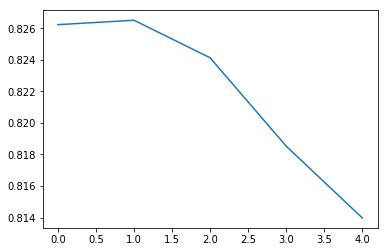

In [61]:
plot(acc_scores[:,0,:][7])

In [ ]:
filename = 'results_training/TRAIN_toy_test_epochs'+str(FLAGS.epochs)+'_h1'+str(FLAGS.hidden1)+\
           '_h2'+str(FLAGS.hidden2)+'_lr'+str(FLAGS.learning_rate)+'dropout'+str(FLAGS.dropout)
with open(filename, 'wb') as f:
    pickle.dump(output_data, f, protocol=2)